# **Lung Diseases X-Rays**

Authors:

- Lorenzo Saracino (5207520)
- Matteo Barbieri (5208190)

Dataset link: [Lung X-Rays (grayscale)](https://www.kaggle.com/datasets/samuel156/lungxrays-grayscale)

\
The Lung Diseases X-Rays (Grayscale) dataset is a collection of grayscale X-Ray images representing various lung diseases, including COVID-19, pneumonia, tuberculosis, along with images of normal lungs.
\
Images are gathered from various origins and subjected to preprocessing to guarantee consistent size and resolution.
\
The dataset is specifically designed for the development and exploration of deep learning models focused on classifying lung diseases through the usage of medical imaging. The primary goal is to predict the class to which the X-ray image belongs.
\
The dataset includes 4 classes and 8106 X-ray images, splitted in this way:
- 2031 images for `Corona Virus Disease`;
- 2013 images for `Normal`;
- 2031 images for `Pneumonia`;
- 2031 images for `Tuberculosis`.

The dataset is organized into three main directories:

* train: 4861 images used for training machine learning models;
* test: 1625 images reserved for testing the trained models;
* validation: 1620 images employed for assessing model performance.

In each of these directories, images are further organized into subdirectories according to their respective classes, guaranteeing a well-balanced representation of images for each specific condition.

In [ ]:
%%capture
# libraries
!pip install d2l==1.0.0a1.post0
!pip install split-folders
!pip install torchviz

import os, os.path, shutil
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import numpy as np
import pandas as pd
from torch import nn
from torch.nn import functional as F
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms, datasets
from torch.utils import data
from d2l import torch as d2l
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import splitfolders
import warnings
d2l.use_svg_display()
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchviz import make_dot
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# Data preparation and exploration

In the first section, emphasis is placed on conducting exploratory analysis of data and preparing the dataset for subsequent models implementation.

In [ ]:
base_path = "/content/drive/MyDrive/LungXRays"
test_path = os.path.join(base_path, "test")
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")

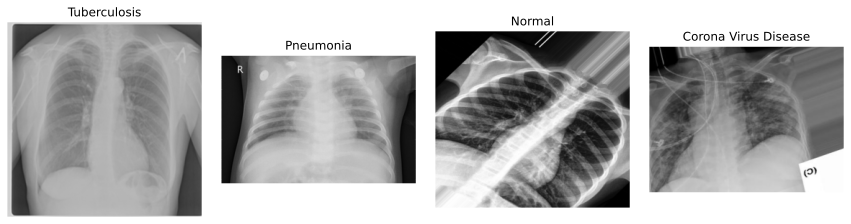

In [ ]:
categories = ["Tuberculosis", "Pneumonia", "Normal", "Corona Virus Disease"]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 18))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, category in enumerate(categories):
    category_path = os.path.join(train_path, category)
    image_file = os.listdir(category_path)[1]
    image_path = os.path.join(category_path, image_file)

    image = cv2.imread(image_path)
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(category)
    ax.axis("off")

plt.show()

Here, images corresponding to each class are presented to gain an understanding of the nature of the data that will be handled.

To illustrate the sizes of categories across various dataset splits (train, test and validation), bar charts were employed. Each subplot represents the number of images per category, offering a visual overview of the data distribution within each set.

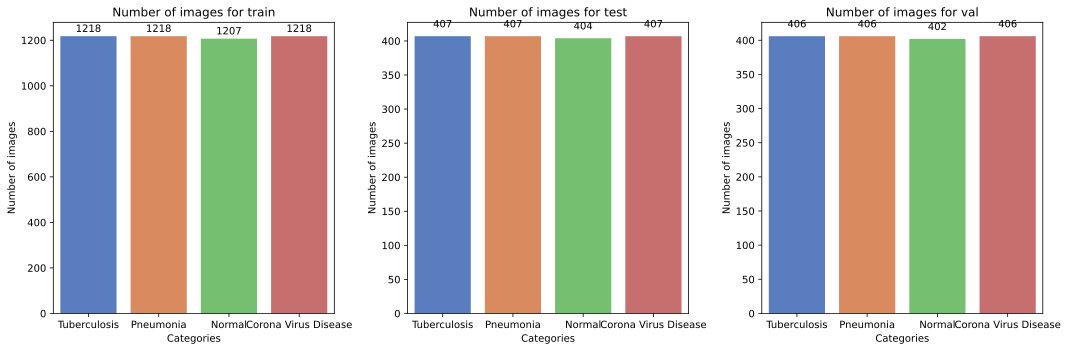

In [ ]:
def get_category_sizes(data_split_path):
    categories_size = []
    for category in categories:
        dir_path = os.path.join(data_split_path, category)
        count = len(os.listdir(dir_path))
        categories_size.append(count)
    return categories_size


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, data_split_path in enumerate([train_path, test_path, val_path]):
    categories_size = get_category_sizes(data_split_path)
    ax = sns.barplot(x=categories, y=categories_size, palette = "muted", ax=axs[i])
    for j, v in enumerate(categories_size):
        ax.text(j, v + 10, str(v), color='black', ha='center', va='bottom')
    ax.set_title(f'Number of images for {data_split_path.split("/")[-1]}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Number of images')

plt.tight_layout()
plt.show()

The distribution of category frequencies for each set shows a perfect balance, suggesting notable consistency of data, that is a crucial aspect for conducting further comprehensive analyses.

Another analytical exploration involves gathering insights into the distribution of both height and width across our images. This is made in order to have a better understanding of the data.

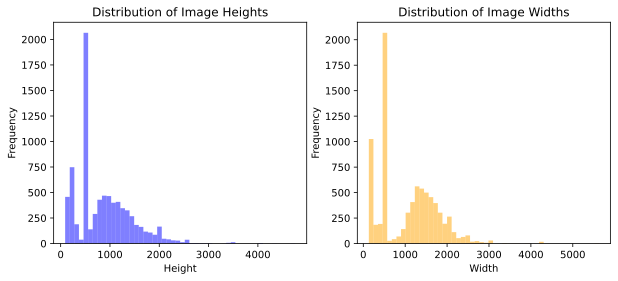

In [ ]:
image_dimensions = []

for category in categories:
    for data_split in ["train", "test", "val"]:
        split_path = os.path.join(base_path, data_split, category)

        for img_name in os.listdir(split_path):
            img_path = os.path.join(split_path, img_name)
            img = cv2.imread(img_path)

            height, width, _ = img.shape
            image_dimensions.append((height, width))

image_dimensions = np.array(image_dimensions)

fig, axs = plt.subplots(1, 2, figsize= (10, 4))

axs[0].hist(image_dimensions[:, 0], bins=50, alpha=0.5, color='blue', label='Height')
axs[0].set_title('Distribution of Image Heights')
axs[0].set_xlabel('Height')
axs[0].set_ylabel('Frequency')

axs[1].hist(image_dimensions[:, 1], bins=50, alpha=0.5, color='orange', label='Width')
axs[1].set_title('Distribution of Image Widths')
axs[1].set_xlabel('Width')
axs[1].set_ylabel('Frequency')

plt.show()


In [ ]:
min_height = np.min(image_dimensions[:, 0])
max_height = np.max(image_dimensions[:, 0])
min_width = np.min(image_dimensions[:, 1])
max_width = np.max(image_dimensions[:, 1])

print(f"height range: from {min_height} to {max_height} pixels")
print(f"width range: from {min_width} to {max_width} pixels")

height range: from 91 to 4757 pixels
width range: from 132 to 5623 pixels


The two histograms indicate that the mode of height frequencies for the images ranges from 500 to 600 pixels, while the mode of width ranges from 400 to 500 pixels.
\
Moreover, the representation above underscores the extensive variation in dimension within the lung X-Ray frames, ranging from approximately 100 pixels for smaller images to dimensions reaching around 5000 pixels for the biggest ones.


To investigate better this point, the images with the maximum width and height are identified within the three sets of data (validation, training, and testing).

In [ ]:
def find_max_size(base_path, categories):
    max_h = 0
    max_w = 0
    max_h_img = None
    max_w_img = None

    for dataset in ["train", "val", "test"]:
        dataset_path = os.path.join(base_path, dataset)

        for category in categories:
            subfolder_path = os.path.join(dataset_path, category)

            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)

                with Image.open(file_path) as img:
                   w = img.size[0]
                   h = img.size[1]

                if h >= max_h:
                    max_h = h
                    max_h_img = file_path

                if w >= max_w:
                    max_w = w
                    max_w_img = file_path

    return max_h_img, max_w_img

In [ ]:
big_h_img, big_w_img = find_max_size(base_path, categories)

The image with the biggest heigth has dimensions: (5623, 4757)
The image with the biggest width has dimensions: (5623, 4757)


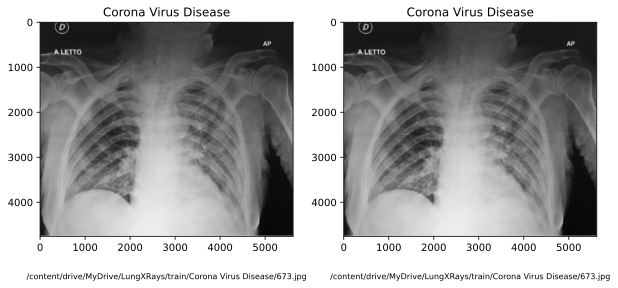

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

image_h = Image.open(big_h_img)
print("The image with the biggest heigth has dimensions:", image_h.size)
axes[0].imshow(image_h, cmap='gray')
axes[0].set_title(categories[categories.index(big_h_img.split(os.sep)[-2])])
axes[0].text(0.5, -0.2, big_h_img, size=8, ha="center", transform=axes[0].transAxes)

image_w = Image.open(big_w_img)
print("The image with the biggest width has dimensions:", image_w.size)
axes[1].imshow(image_w, cmap='gray')
axes[1].set_title(categories[categories.index(big_w_img.split(os.sep)[-2])])
axes[1].text(0.5, -0.2, big_w_img, size=8, ha="center", transform=axes[1].transAxes)


plt.show()

The image *673.jpg*, which represents a lung X-Ray with Corona Virus disease derived from the training set, is the one with both the maximum width and maximum height among all the data.

Now, data preprocessing is configured by specific operations such as resizing images, converting them to tensors, creating the dataset with ImageFolders and the dataloader responsible for the actual loading of data during training.
\
This is an essential preparation and loading of image data for a neural network classification task.

In [ ]:
batch_size=64

resized_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


train_dataset = ImageFolder(train_path, transform=resized_img)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers= 2)


test_dataset = ImageFolder(test_path, transform=resized_img)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers= 2)


val_dataset = ImageFolder(val_path, transform=resized_img)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers= 2)

Within our dataset, images are originally in grayscale. However, during the Python reading process, these images are interpreted in the RGB format. To stay faithful to our original dataset,  **num_output_channels == 1** is specified during the image reading. This parameter is crucial to obtain a single-channel output representation, ensuring that the images are returned in the correct grayscale format.

Check to be sure that the images are in grayscale.

In [ ]:
def contains_color_images(dataset_path):
    all_image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(dataset_path) for file in files]

    for image_path in all_image_paths:
        with Image.open(image_path) as img:
            if img.mode != 'L':
                return True

    return False

contains_color_train = contains_color_images(train_path)
contains_color_test = contains_color_images(test_path)
contains_color_val = contains_color_images(val_path)

print("Train dataset contains color images:", contains_color_train,"; all images are in grayscale.")
print("Test dataset contains color images:", contains_color_test,"; all images are in grayscale.")
print("Validation dataset contains color images:", contains_color_val,"; all images are in grayscale.")

Train dataset contains color images: False ; all images are in grayscale.
Test dataset contains color images: False ; all images are in grayscale.
Validation dataset contains color images: False ; all images are in grayscale.


Now, the training function is implemented to enable the execution of upcoming models.


In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, val_iter, num_epochs, lr, device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)  # Xavier parameter initialization
    net.apply(init_weights)
    print('training on', device)

    net.to(device)  # Move the net to the GPU (if available)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()  # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)  # Move each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():  # Detach gradient calculation to avoid affecting backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))

        val_acc = evaluate_accuracy_gpu(net, val_iter)
        animator.add(epoch + 1, (None, None, val_acc))

    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'validation acc {val_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# First model: GoogleNet

The first model implemented in order to classify the lung disease X-Rays images is GoogleNet architecture.
\
GoogleNet is a convolutional neural network recognized for its intricate architecture. Its distinctive feature is the use of *inception modules*, which are blocks that perform convolutions with multiple parallel filters simultaneously. This design facilitates an efficient information extraction at multiple scales, promoting robustness in image recognition tasks.

Structure of the Inception block → four parallel paths, concatenated to obtain the block output:

![Image1](https://d2l.ai/_images/inception.svg)

The inception block structure is now created.

In [ ]:
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3 convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5 convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1 convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))

        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
s1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
s2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
s3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
s4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
s5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

GoogleNet = nn.Sequential(s1, s2, s3, s4, s5, nn.Linear(1024, 4))

In [ ]:
batch_size = 64
X = torch.rand(size=(batch_size, 1, 224, 224))
for layer in GoogleNet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([64, 64, 56, 56])
Sequential output shape:	 torch.Size([64, 192, 28, 28])
Sequential output shape:	 torch.Size([64, 480, 14, 14])
Sequential output shape:	 torch.Size([64, 832, 7, 7])
Sequential output shape:	 torch.Size([64, 1024])
Linear output shape:	 torch.Size([64, 4])


After implementing the architectural structure,  the model undergoes training and testing to evaluate the model's generalization performance and its effectiveness in handling previously unseen examples.

loss 1.049, train acc 0.501, validation acc 0.586
301.0 examples/sec on cuda:0


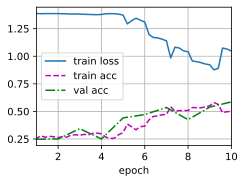

In [ ]:
learning_rate = 0.1
num_epochs = 10
train(GoogleNet, train_dataloader, val_dataloader, num_epochs, learning_rate, device=d2l.try_gpu())

The blue line depicts the training loss, gradually decreasing after each epoch. The purple line represents the training accuracy, while the green one illustrates the validation accuracy, evidencing some oscillations, which suggest a bit of overfitting.
\
Overfitting occurs when a model learns the training data too well, capturing noise and fluctuations that may not generalize well to the new and unseen data.
\
Despite having tried with various levels of learning rate, after 10 epochs, the training accuracy approximates 50%, indicating not a very good capability of the model in correctly identifying the true labels of the images.

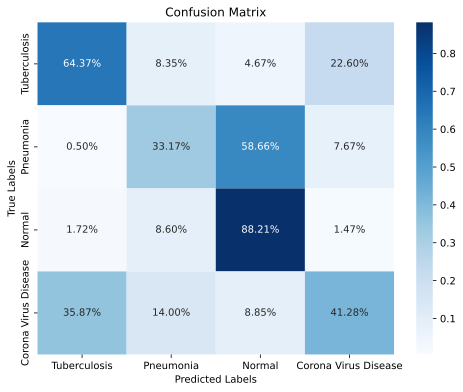

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GoogleNet.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_hat = GoogleNet(X)
        all_preds.extend(torch.argmax(y_hat, dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

confusion_matrix_sum = confusion_matrix(all_labels, all_preds, labels=np.arange(4))

confusion_matrix_percentage = confusion_matrix_sum.astype('float') / confusion_matrix_sum.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The primary issues become apparent when analyzing the confusion matrix. GoogleNet faces challenges in accurately predicting pneumonia, as it tends to misclassify it with normal X-Rays 58.66% of the time and also problems in the detection of Corona Virus Disease, misclassifying it with Tubercolosis 35.87% of the time.

In [ ]:
report1 = classification_report(all_labels, all_preds, target_names=categories)
print(report1)

                      precision    recall  f1-score   support

        Tuberculosis       0.63      0.64      0.64       407
           Pneumonia       0.52      0.33      0.40       404
              Normal       0.55      0.88      0.68       407
Corona Virus Disease       0.57      0.41      0.48       407

            accuracy                           0.57      1625
           macro avg       0.57      0.57      0.55      1625
        weighted avg       0.57      0.57      0.55      1625



The most crucial metric is important to focus on is the test accuracy, which, as evident from the table, stands at approximately 57%.
\
Given the medical context of our dataset and the number of classes, a 57% accuracy is considered relatively low. Consequently, alternative architectures will be explorated to enhance predictions.

# Second model : AlexNet

It was interesting to determine whether the accuracy would have been improved with respect to GoogleNet, and this led to the implementation of AlexNet.
\
This is an innovative convolutional neural network architecture notable for its success in the ImageNet competition. The structure consists of five convolutional layers followed by three fully connected layers, employing ReLU activation and dropout for regularization.

A representation of AlexNet:
![Image2](https://www.researchgate.net/publication/319148488/figure/fig1/AS:11431281211855238@1702499052460/The-AlexNet-architecture.tif)

The structure of the model:

In [ ]:
AlexNet = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4)
)

In [ ]:
X = torch.randn(batch_size, 1, 224, 224)
for layer in AlexNet:
    X=layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([64, 96, 54, 54])
ReLU Output shape:	 torch.Size([64, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([64, 96, 26, 26])
Conv2d Output shape:	 torch.Size([64, 256, 26, 26])
ReLU Output shape:	 torch.Size([64, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([64, 256, 12, 12])
Conv2d Output shape:	 torch.Size([64, 384, 12, 12])
ReLU Output shape:	 torch.Size([64, 384, 12, 12])
Conv2d Output shape:	 torch.Size([64, 384, 12, 12])
ReLU Output shape:	 torch.Size([64, 384, 12, 12])
Conv2d Output shape:	 torch.Size([64, 256, 12, 12])
ReLU Output shape:	 torch.Size([64, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([64, 256, 5, 5])
Flatten Output shape:	 torch.Size([64, 6400])
Linear Output shape:	 torch.Size([64, 4096])
ReLU Output shape:	 torch.Size([64, 4096])
Dropout Output shape:	 torch.Size([64, 4096])
Linear Output shape:	 torch.Size([64, 4096])
ReLU Output shape:	 torch.Size([64, 4096])
Dropout Output shape:	 torch.Size([64, 4096])
Linear Output sh

After implementing the architectural structure, the model is subjected to training and testing.

loss 0.421, train acc 0.842, validation acc 0.812
944.0 examples/sec on cuda:0


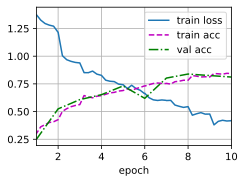

In [ ]:
learning_rate = 0.05
num_epochs = 10
train(AlexNet, train_dataloader, val_dataloader, num_epochs, learning_rate, device=d2l.try_gpu())

In this second case, the learning rate, after different trials, has been adjusted, choosing 0.05, in order to use the best one in terms of results and convergence of the model.
\
The training plot seems to be significantly better with respect to the plot of GoogleNet, both in terms of training loss and accuracy. Moreover, the oscillations of the validation accuracy have been reduced, indicating an improvement concerning overfitting.
\
The test accuracy achieved with AlexNet is nearly 84%, while the validation accuracy is 81%, indicating a notable improvement compared to GoogleNet.



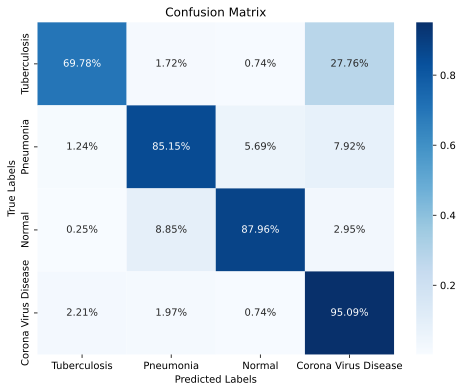

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AlexNet.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_hat = AlexNet(X)
        all_preds.extend(torch.argmax(y_hat, dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

confusion_matrix_sum = confusion_matrix(all_labels, all_preds, labels=np.arange(4))

confusion_matrix_percentage = confusion_matrix_sum.astype('float') / confusion_matrix_sum.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report2 = classification_report(all_labels, all_preds, target_names=categories)
print(report2)

                      precision    recall  f1-score   support

        Tuberculosis       0.95      0.70      0.80       407
           Pneumonia       0.87      0.85      0.86       404
              Normal       0.93      0.88      0.90       407
Corona Virus Disease       0.71      0.95      0.81       407

            accuracy                           0.84      1625
           macro avg       0.86      0.84      0.85      1625
        weighted avg       0.86      0.84      0.85      1625



Both the confusion matrix and the metrics above seem to be definitely better with respect to GoogleNet. The model is able to predict much better than before both Pneumonia and Corona Virus disease.
\
In addition, the test accuracy calculated on new unseen data increased by 27% with respect to GoogleNet's, reaching 84%.

# Data augmentation

To improve even more the classification task, the more effective model of the two (AlexNet) was selected as the basis for developing a new customized model.
\
Subsequent adjustments were made to improve overall accuracy and the predictive performance of the model for X-Ray lung images.

<br>

The initial adjustment implemented for the new model involves performing data augmentation on the images.
\
Data augmentation involves creating variations in the training dataset by applying transformations such as rotations, flips, and zooms to the existing images. The purpose is to increase the diversity and quantity of training data, thereby boosting the model's ability to generalize with different conditions. This technique is particularly useful in preventing overfitting, improving model robustness, and ultimately enhancing the performance of machine learning models.

In [ ]:
torch.manual_seed(21040)

aug_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p = 0.8),
    transforms.ColorJitter(brightness=1.1, contrast=0.9),
    transforms.RandomAffine(degrees=0, scale=(1.15, 1.15), shear=0, translate=(0, 0))
    ])

Specifically, main transformations that have been performed are:


1.   **Resizing of the images** (already used in the previous models): this uniformely resizes all images in 224x224, necessary to use as an input of AlexNet based-model;
2.   **Random Horizontal flip**: it flips the images horizontally with a probability of 0.8;
3.  **ColorJitter color variation**: this introduces random variations in the color channels of images, providing increased diversity during model training. This improves the model's robustness to diverse lighting and color conditions encountered in real-world data. Having grayscale images this function is used to modify brightness and contrast;
4. **RandomAffine zoom augmentation**: it applies random geometric transformations to images such as rotations, translations, zooms, and shears. This variety of geometric transformations enables the model to learn features that are invariant to different positions and orientations of objects in images, thereby improving its generalization capabilities. In this specific case, a slight zoom is applied to point out better all the details of the images.



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


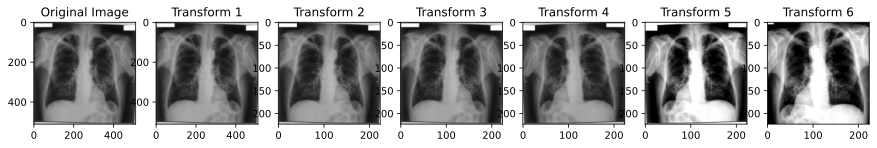

In [ ]:
image_path = "/content/drive/MyDrive/LungXRays/train/Tuberculosis/487.jpg"
original_image = Image.open(image_path)


plt.figure(figsize=(15, 6))
plt.subplot(1, 7, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")

torch.manual_seed(21040)

transformations = [
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.ColorJitter(brightness=1.1, contrast=0.9),
    transforms.RandomAffine(degrees=0, scale=(1.15, 1.15), shear=0, translate=(0, 0))
]

transformed_image = original_image
for i, transformation in enumerate(transformations, start=2):
    transformed_image = transformation(transformed_image)
    transformed_image_np = np.asarray(transformed_image)
    transformed_image_np = np.squeeze(transformed_image_np)

    plt.subplot(1, 7, i)
    plt.imshow(transformed_image_np, cmap='gray')
    plt.title(f"Transform {i-1}")

plt.show()

The representation above shows all the steps that have been executed in data augmentation in order to understand all the trasformations of the images.

All the images in the train dataset have faced data augmentation and have been subsequently concatenated with the existing train dataset containing original images.
\
The *new_train_dataset* now contains both the original frames and the augmented ones, doubling the amount of available data.

In [ ]:
batch_size = 64

aug_dataset = ImageFolder(train_path, transform = aug_data)
new_train_dataset = torch.utils.data.ConcatDataset([train_dataset, aug_dataset])
new_train_loader = DataLoader(new_train_dataset, batch_size = batch_size, shuffle=True, num_workers= 2)

# New customized model

The customized architecture based on AlexNet is implemented adding also those particular features to its structure:

1. **Batch normalization** *(nn.BatchNorm1d)*:
Batch normalization is a widely adopted and efficient technique known for consistently accelerating the convergence of deep networks. This technique provides several advantages, including preprocessing, numerical stability, and regularization. Batch normalization is implemented in this case after the initial two fully connected layers. During each training iteration, the inputs for batch normalization are normalized by subtracting their mean and dividing by their standard deviation. These statistical parameters are estimated based on the current minibatch. Subsequently, a scale coefficient, which is used to stretch the normalized input, and an offset, that shifts the normalized input, are applied to restore the lost degrees of freedom.
2. **Dropout** *(nn.Dropout)*: Dropout is a regularization technique used during training and implemented with a probability of 0.4 after each fully connected layer. It involves randomly "dropping out" a fraction of neurons, preventing overfitting; this means that during each training iteration, a different subset of neurons is deactivated, forcing the model to learn more robust and generalized features.



In [ ]:
AlexNet_aug = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.BatchNorm1d(4096),
    nn.Dropout(p=0.4),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.BatchNorm1d(4096),
    nn.Dropout(p=0.4),
    nn.Linear(4096, 4)
)

In [ ]:
X = torch.randn(batch_size, 1, 224, 224)

for layer in AlexNet_aug:
    X = layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([64, 96, 54, 54])
ReLU Output shape:	 torch.Size([64, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([64, 96, 26, 26])
Conv2d Output shape:	 torch.Size([64, 256, 26, 26])
ReLU Output shape:	 torch.Size([64, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([64, 256, 12, 12])
Conv2d Output shape:	 torch.Size([64, 384, 12, 12])
ReLU Output shape:	 torch.Size([64, 384, 12, 12])
Conv2d Output shape:	 torch.Size([64, 384, 12, 12])
ReLU Output shape:	 torch.Size([64, 384, 12, 12])
Conv2d Output shape:	 torch.Size([64, 256, 12, 12])
ReLU Output shape:	 torch.Size([64, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([64, 256, 5, 5])
Flatten Output shape:	 torch.Size([64, 6400])
Linear Output shape:	 torch.Size([64, 4096])
ReLU Output shape:	 torch.Size([64, 4096])
BatchNorm1d Output shape:	 torch.Size([64, 4096])
Dropout Output shape:	 torch.Size([64, 4096])
Linear Output shape:	 torch.Size([64, 4096])
ReLU Output shape:	 torch.Size([64, 4096])
BatchNorm1d 

Again, after implementing the architectural structure, the model undergoes training and testing to evaluate its accuracy in predicting unseen data.

loss 0.643, train acc 0.760, validation acc 0.826
897.1 examples/sec on cuda:0


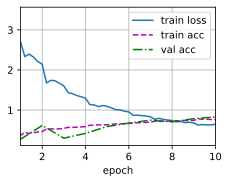

In [ ]:
learning_rate = 0.01
num_epochs = 10
train(AlexNet_aug, new_train_loader, val_dataloader, num_epochs, learning_rate, device=d2l.try_gpu())

For this customized model as well, a learning rate of 0.01 was selected after several attempts, with the aim of achieving optimal results in both performance and model convergence.
\
The issue of overfitting, indicated by oscillations in validation accuracy, is slightly reduced once again, as observed in the consistent upward trend of the green line, except for a little variation between the second and third epoch.

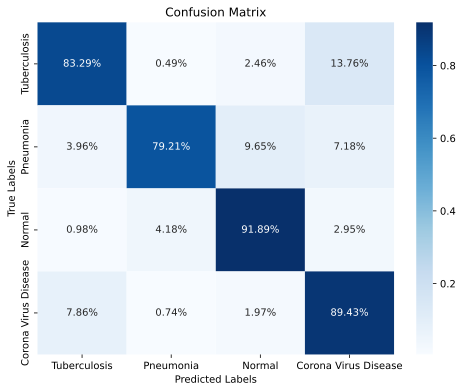

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AlexNet_aug.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_hat = AlexNet_aug(X)
        all_preds.extend(torch.argmax(y_hat, dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

confusion_matrix_sum = confusion_matrix(all_labels, all_preds, labels=np.arange(4))

confusion_matrix_percentage = confusion_matrix_sum.astype('float') / confusion_matrix_sum.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report3 = classification_report(all_labels, all_preds, target_names=categories)
print(report3)

                      precision    recall  f1-score   support

        Tuberculosis       0.87      0.83      0.85       407
           Pneumonia       0.94      0.79      0.86       404
              Normal       0.87      0.92      0.89       407
Corona Virus Disease       0.79      0.89      0.84       407

            accuracy                           0.86      1625
           macro avg       0.87      0.86      0.86      1625
        weighted avg       0.86      0.86      0.86      1625



As it is possible to see from the confusion matrix and from the metrics, the customized model seems to behave better with respect to both the previous models. Indeed, the accuracy, reaches the 86%, a slight improvement of 2% with respect to basic AlexNet. All the predictions for each class improve significantly and all classes have a precision of at least 79%.

# Conclusions and possible applications


It is possible to conclude that the final customized AlexNet with batch normalization, dropouts and the augmented images is the one performing better among all the models executed. This means that the 86% of images of the lung disease X-Rays dataset are correctly predicted by the model.
<br>
<br>
This model could be really interesting to test on other different real clinical cases.
Based on actual clinical research, chest X-Ray is capable of detecting the majority of lung tumors, but it may not reveal small-sized ones.
\
New CNN-based architectures, such as the one suggested in the previous section, tailored to the specific task, can be instrumental in identifying elusive patterns in images that might go unnoticed by the naked eye. This is particularly relevant in cases like the detection of small tumors or other diseases.
